In [1]:
import os
import zipfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
local_zip = '/content/drive/MyDrive/scalp_image_model.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')

In [4]:
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
base_dir = '/content'

train_dir = os.path.join(base_dir,'training')
val_dir = os.path.join(base_dir,'validation')
test_dir = os.path.join(base_dir,'test')

In [6]:
train_bd_train_dir = os.path.join(train_dir,'bd_train')
train_hb_train_dir = os.path.join(train_dir,'hb_train')
train_tm_train_dir = os.path.join(train_dir,'tm_train')   
train_pj_train_dir = os.path.join(train_dir,'pj_train')
train_gj_train_dir = os.path.join(train_dir,'gj_train')

In [7]:
train_bd_dir = os.path.join(train_bd_train_dir,'zbd')
train_hb_dir = os.path.join(train_hb_train_dir,'zhb')
train_tm_dir = os.path.join(train_tm_train_dir,'ztm')
train_pj_dir = os.path.join(train_pj_train_dir,'zpj')
train_gj_dir = os.path.join(train_gj_train_dir,'zgj')

In [8]:
val_bd_val_dir = os.path.join(val_dir,'bd_val')
val_hb_val_dir = os.path.join(val_dir,'hb_val')
val_tm_val_dir = os.path.join(val_dir,'tm_val')   
val_pj_val_dir = os.path.join(val_dir,'pj_val')
val_gj_val_dir = os.path.join(val_dir,'gj_val')

In [9]:
val_bd_dir = os.path.join(val_bd_val_dir,'zbd')
val_hb_dir = os.path.join(val_hb_val_dir,'zhb')
val_tm_dir = os.path.join(val_tm_val_dir,'ztm')   
val_pj_dir = os.path.join(val_pj_val_dir,'zpj')
val_gj_dir = os.path.join(val_gj_val_dir,'zgj')

In [10]:
test_bd_test_dir = os.path.join(test_dir,'bd_test')
test_hb_test_dir = os.path.join(test_dir,'hb_test')
test_tm_test_dir = os.path.join(test_dir,'tm_test')
test_pj_test_dir = os.path.join(test_dir,'pj_test')
test_gj_test_dir = os.path.join(test_dir,'gj_test')

In [11]:
test_bd_dir = os.path.join(test_dir,'zbd')
test_hb_dir = os.path.join(test_dir,'zhb')
test_tm_dir = os.path.join(test_dir,'ztm')
test_pj_dir = os.path.join(test_dir,'zpj')
test_gj_dir = os.path.join(test_dir,'zgj')

In [12]:
train_bd_fnames=os.listdir(train_bd_dir)
train_hb_fnames=os.listdir(train_hb_dir)
train_tm_fnames=os.listdir(train_tm_dir)
train_pj_fnames=os.listdir(train_pj_dir)
train_gj_fnames=os.listdir(train_gj_dir)

In [13]:
val_bd_fnames=os.listdir(val_bd_dir)
val_hb_fnames=os.listdir(val_hb_dir)
val_tm_fnames=os.listdir(val_tm_dir)
val_pj_fnames=os.listdir(val_pj_dir)
val_gj_fnames=os.listdir(val_gj_dir)

In [14]:
batch_size = 32
epochs = 20
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

In [16]:
train_gen = train_datagen.flow_from_directory(batch_size=batch_size,
                                              directory=train_gj_train_dir,
                                              shuffle=True,
                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                              class_mode='binary')

Found 1600 images belonging to 2 classes.


In [17]:
val_gen = test_datagen.flow_from_directory(batch_size=batch_size,
                                          directory=val_gj_val_dir,
                                          shuffle=True,
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          class_mode='binary')

Found 400 images belonging to 2 classes.


In [18]:
sample_training_images, _ = next(train_gen)
sample_val_images, _ = next(val_gen)

In [19]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

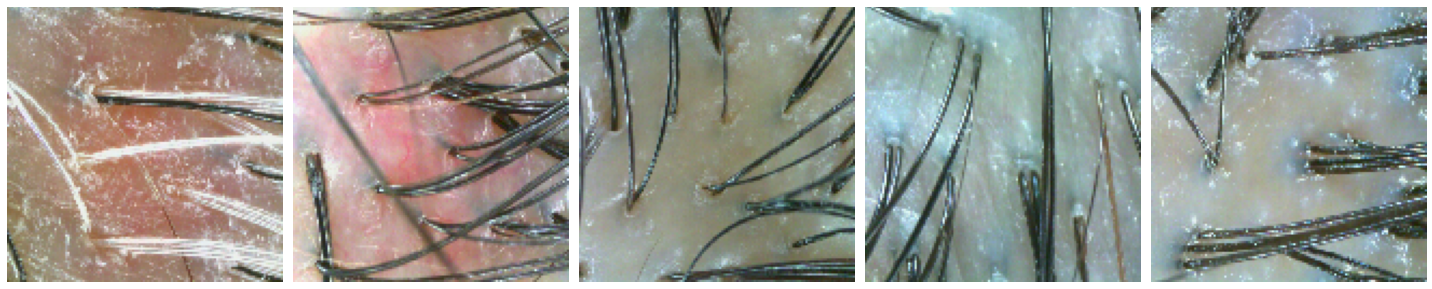

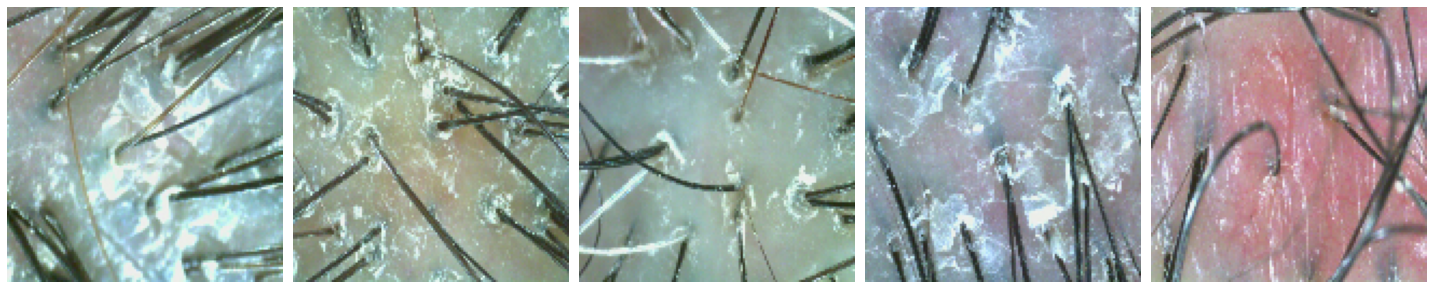

In [20]:
import matplotlib.pyplot as plt
plotImages(sample_training_images[:5])
plotImages(sample_val_images[:5])

In [21]:
from tensorflow.keras.applications import MobileNetV2

mobile = MobileNetV2(weights = 'imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top = False)
mobile.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
________________

In [22]:
for layer in mobile.layers[:-4]:
    layer.trainable = False

In [23]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(mobile)
model.add(Dropout(0.3))
model.add(Conv2D(filters = 256, kernel_size = 3, activation='relu',input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(Dropout(0.3))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 128, kernel_size = 3, padding="SAME", activation = 'relu', kernel_regularizer = l2(0.001)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 64, kernel_size = 3, padding="SAME", activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 32, kernel_size = 3, padding="SAME", activation = 'relu', kernel_regularizer = l2(0.001)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1280)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 256)         2949376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 2, 256)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 256)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 1, 256)         0         
_________________________________________________________________
dense (Dense)                (None, 1, 1, 128)         3

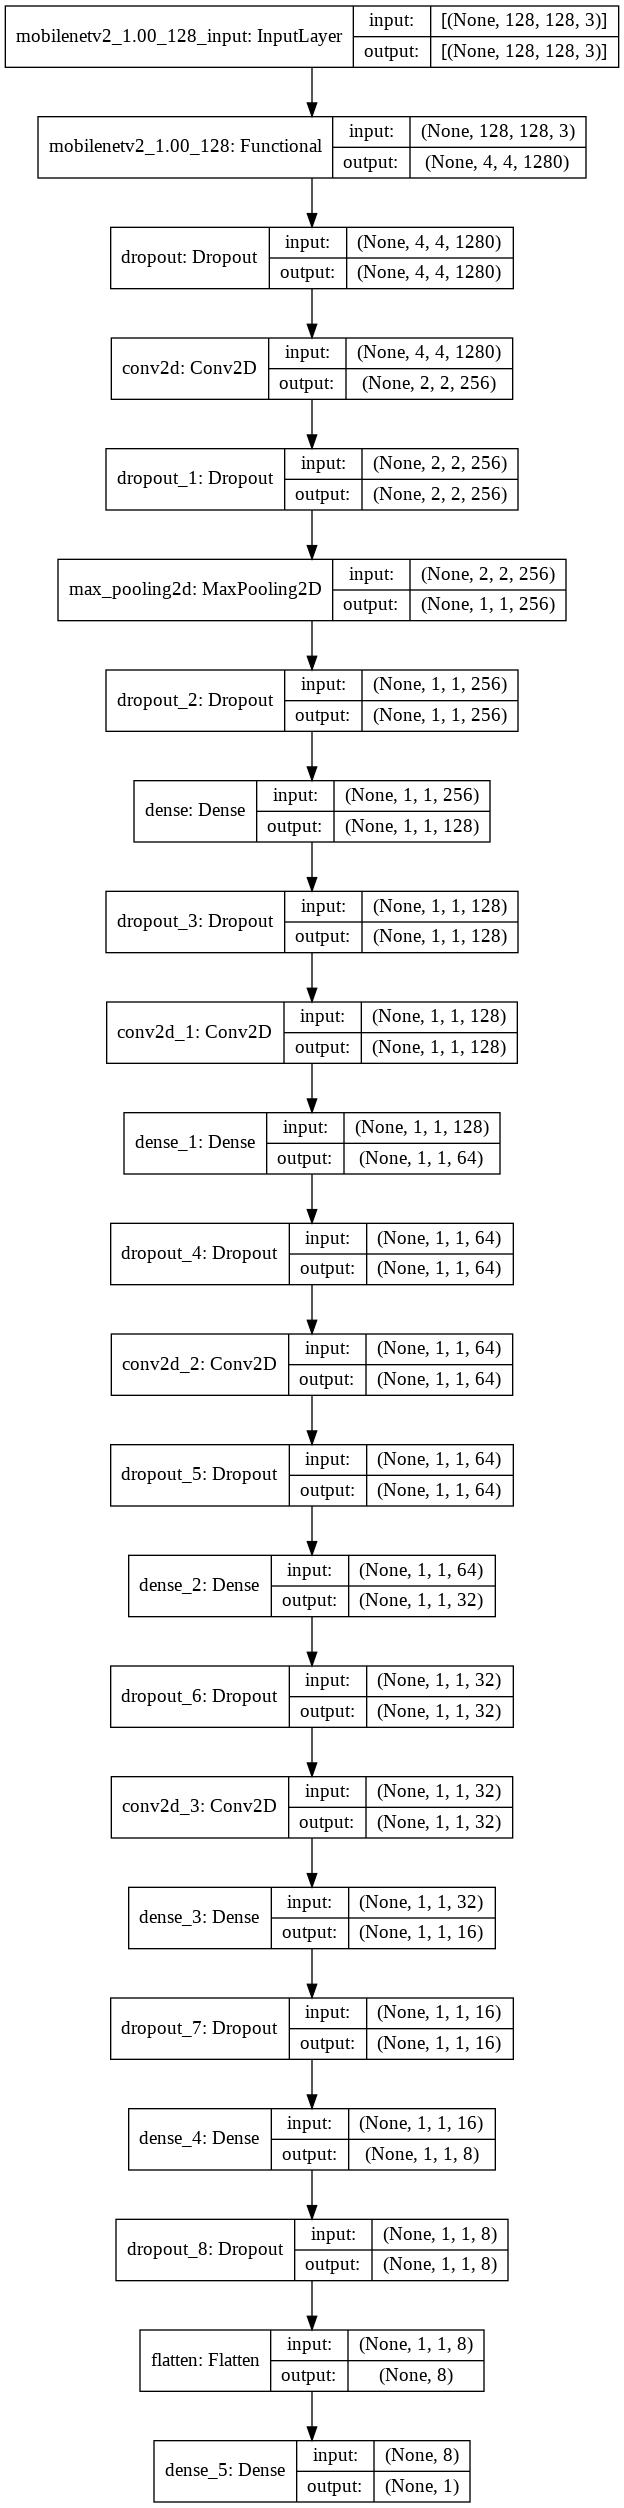

In [25]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file = 'model.jpg', show_shapes = True)

In [26]:
from datetime import datetime
import os
import keras

In [27]:
save_dir = '/content/drive/MyDrive/'
project_name = 'gj_CNN_model'

In [28]:
def save_file():
  time = datetime.today()
  yy = time.year
  mon = time.month
  time_name = str(yy) + str(mon) + '_my_' + project_name + '.h5'
  file_name = os.path.join(save_dir, time_name)
  return file_name

In [29]:
callbacks = [
             keras.callbacks.TensorBoard(
                 log_dir = save_dir,
                 write_graph = True,
                 write_images = True
             ),
             keras.callbacks.EarlyStopping(
                 monitor = 'val_acc',
                 patience = 10
             ),
             keras.callbacks.ModelCheckpoint(
                 filepath = save_file(),
                 monitor = 'val_loss',
                 save_best_only = True
             )
]

In [30]:
history = model.fit(
    train_gen,
    steps_per_epoch= 1000//batch_size,
    epochs = 50,
    validation_data = val_gen,
    validation_steps= 304//batch_size,
    callbacks = callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
31/31 [==============================] - 30s 346ms/step - loss: 0.8371 - acc: 0.4798 - val_loss: 0.8249 - val_acc: 0.4549
Epoch 2/50
31/31 [==============================] - 9s 290ms/step - loss: 0.8155 - acc: 0.4940 - val_loss: 0.8059 - val_acc: 0.5521
Epoch 3/50
31/31 [==============================] - 9s 290ms/step - loss: 0.7979 - acc: 0.5121 - val_loss: 0.7897 - val_acc: 0.4896
Epoch 4/50
31/31 [==============================] - 9s 292ms/step - loss: 0.7821 - acc: 0.4909 - val_loss: 0.7749 - val_acc: 0.5104
Epoch 5/50
31/31 [==============================] - 9s 289ms/step - loss: 0.7685 - acc: 0.5131 - val_loss: 0.7622 - val_acc: 0.5000
Epoch 6/50
31/31 [==============================] - 9s 289ms/step - loss: 0.7571 - acc: 0.4960 - val_loss: 0.7517 - val_acc: 0.4792
Epoch 7/50
31/31 [==============================] - 9s 292ms/step - loss: 0.7470 - acc: 0.4768 - val_loss: 0.7414 - val_acc: 0.5139
Epoch 8/50
31/31 [==============================] - 9s 289ms/step - loss: 0

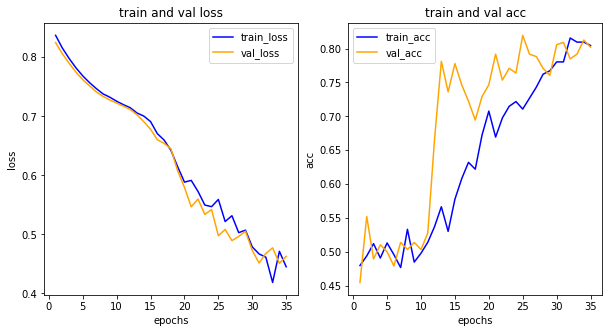

In [31]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))


ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['acc']
val_acc = his_dict['val_acc']


ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

In [32]:
test_gen = test_datagen.flow_from_directory(batch_size=batch_size,
                                          directory=test_gj_test_dir,
                                          shuffle=True,
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          class_mode='binary')

Found 69 images belonging to 2 classes.


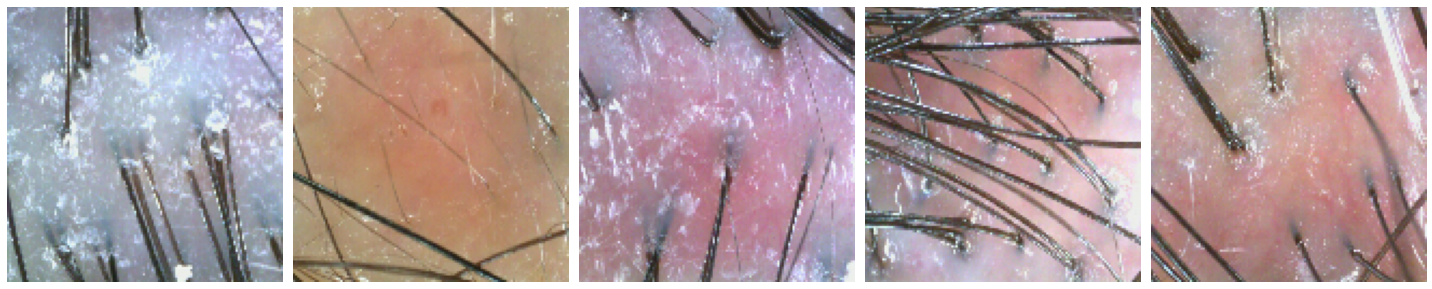

In [33]:
sample_test_images, _ = next(test_gen)
plotImages(sample_test_images[:5])

In [34]:
model.predict(sample_test_images[0].reshape(1,128,128,3))

array([[0.74709404]], dtype=float32)

In [35]:
model.predict(sample_test_images[1].reshape(1,128,128,3))

array([[0.01736849]], dtype=float32)

In [36]:
model.predict(sample_test_images[2].reshape(1,128,128,3))

array([[0.1861636]], dtype=float32)

In [37]:
model.predict(sample_test_images[3].reshape(1,128,128,3))

array([[0.05942442]], dtype=float32)

In [38]:
model.predict(sample_test_images[4].reshape(1,128,128,3))

array([[0.09751417]], dtype=float32)